X_train shape before PCA: (38, 3, 1500)
X_train shape after flattening: (1500, 114)


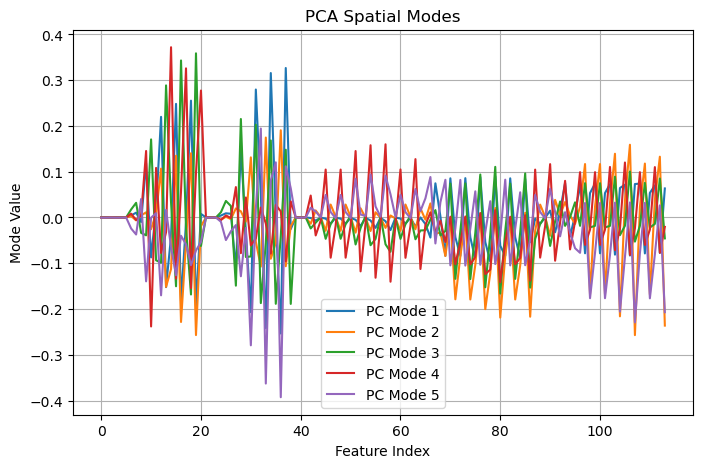

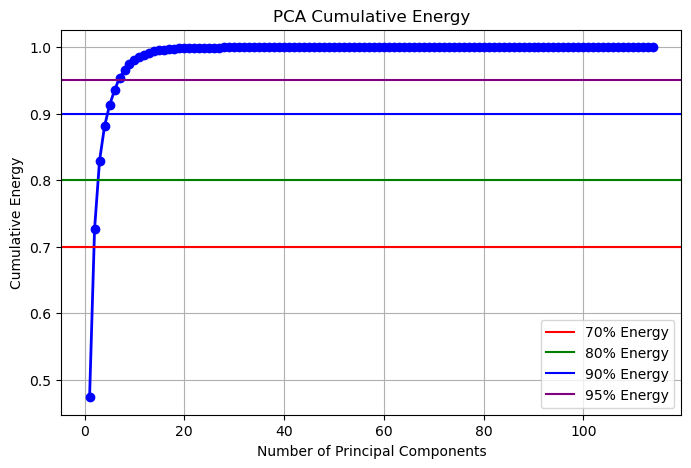

Number of components needed for 70.0% energy: 2
Number of components needed for 80.0% energy: 3
Number of components needed for 90.0% energy: 5
Number of components needed for 95.0% energy: 7


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import glob
import os

folder = "hw2data/train/"
file_list = sorted(glob.glob(os.path.join(folder, '*.npy')))
data_list = [np.reshape(np.load(file)[:,:], (38,3,-1)) for file in file_list]
X_train = np.concatenate(data_list, axis=2)  # Ensure all samples are stacked properly

# Check shape of X_train before PCA
print(f'X_train shape before PCA: {X_train.shape}')

# Flatten the data for PCA
X_train_flat = X_train.reshape(X_train.shape[0] * X_train.shape[1], -1).T

print(f'X_train shape after flattening: {X_train_flat.shape}')

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_train_flat)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Retrieve PCA spatial modes (principal component vectors)
pca_modes = pca.components_

# Plot PCA spatial modes
plt.figure(figsize=(8, 5))
for i in range(5):  # Plot first 5 modes
    plt.plot(pca_modes[i], label=f'PC Mode {i+1}')
plt.xlabel("Feature Index")
plt.ylabel("Mode Value")
plt.title("PCA Spatial Modes")
plt.legend()
plt.grid()
plt.show()

# Plot cumulative energy
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-', linewidth=2)
plt.axhline(y=0.7, color='r', linestyle='-', label='70% Energy')
plt.axhline(y=0.8, color='g', linestyle='-', label='80% Energy')
plt.axhline(y=0.9, color='b', linestyle='-', label='90% Energy')
plt.axhline(y=0.95, color='purple', linestyle='-', label='95% Energy')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Energy')
plt.title('PCA Cumulative Energy')
plt.legend()
plt.grid()
plt.show()

# Output the number of components needed for each energy level
energy_levels = [0.7, 0.8, 0.9, 0.95]
n_components = [np.argmax(explained_variance_ratio >= level) + 1 for level in energy_levels]
for level, num in zip(energy_levels, n_components):
    print(f'Number of components needed for {level*100}% energy: {num}')

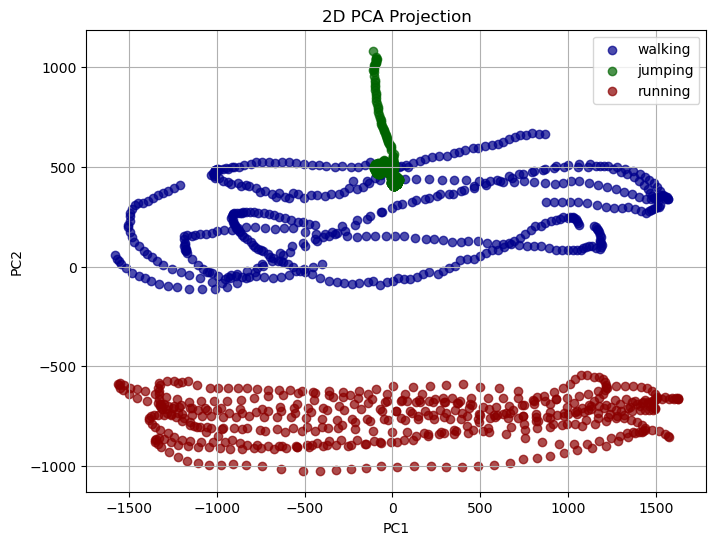

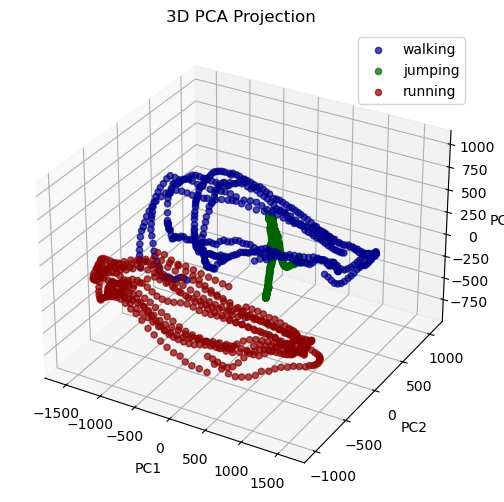

In [8]:
# Truncate PCA to 2 modes
X_pca_2d = X_pca[:, :2]

# # Truncate PCA to 3 modes
X_pca_3d = X_pca[:, :3]

# If you have multiple movement classes (e.g., walking, running, jumping),
# you can map each file's label to an integer and color, as in your example:
labels = [os.path.basename(f).split("_")[0] for f in file_list]  # e.g. "walking", "running", ...
label_map = {"walking": 0, "jumping": 1, "running": 2}
colors = ["darkblue", "darkgreen", "darkred"]

# Expand labels to match the per-frame data points in X_pca
frames_per_sample = X_pca.shape[0] // len(file_list)
expanded_labels = np.repeat([label_map[lbl] for lbl in labels], frames_per_sample)

# 2D Plot of first two PCA components
plt.figure(figsize=(8, 6))
for idx, color in enumerate(colors):
    # Pick points belonging to this class
    class_points = np.where(expanded_labels == idx)[0]
    plt.scatter(
        X_pca_2d[class_points, 0], 
        X_pca_2d[class_points, 1], 
        color=color, alpha=0.7, label=list(label_map.keys())[idx]
    )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection")
plt.legend()
plt.grid(True)
plt.show()

# 3D Plot of first three PCA components
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
for idx, color in enumerate(colors):
    class_points = np.where(expanded_labels == idx)[0]
    ax.scatter(
        X_pca_3d[class_points, 0], 
        X_pca_3d[class_points, 1], 
        X_pca_3d[class_points, 2], 
        color=color, alpha=0.7, label=list(label_map.keys())[idx]
    )
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA Projection")
ax.legend()
plt.show()


In [10]:
# Extract movement labels from filenames
labels = [file.split("/")[-1].split("_")[0] for file in file_list]
label_map = {"walking": 0, "jumping": 1, "running": 2}

ground_truth_labels = np.array([label_map[label] for label in labels])
print("Ground truth labels:")
print(ground_truth_labels)
unique_labels = list(label_map.keys())
colors = ['darkblue', 'darkgreen', 'darkred']
label_color_map = {label: color for label, color in zip(unique_labels, colors)}

# Expand labels to match the number of frames per movement
frames_per_sample = X_pca.shape[0] // len(file_list)  # Calculate frames per movement
expanded_labels = np.repeat(ground_truth_labels, frames_per_sample)  # Repeat labels for each frame

# Compute centroids in k-modes PCA space
k = 2
X_pca_k = X_pca[:, :k]
centroids = {label: np.mean(X_pca_k[expanded_labels == idx], axis=0) for label, idx in label_map.items()}

print("Centroids in k-modes PCA space:")
for label, centroid in centroids.items():
    print(f"{label}: {centroid}")

Ground truth labels:
[1 1 1 1 1 2 2 2 2 2 0 0 0 0 0]
Centroids in k-modes PCA space:
walking: [-36.88211143 253.35282541]
jumping: [-23.88986635 499.36826149]
running: [  60.77197779 -752.7210869 ]


k=1, Classifier accuracy = 50.73%
k=2, Classifier accuracy = 88.13%
k=3, Classifier accuracy = 75.60%
k=4, Classifier accuracy = 73.00%
k=5, Classifier accuracy = 75.07%
k=6, Classifier accuracy = 72.60%
k=7, Classifier accuracy = 87.07%


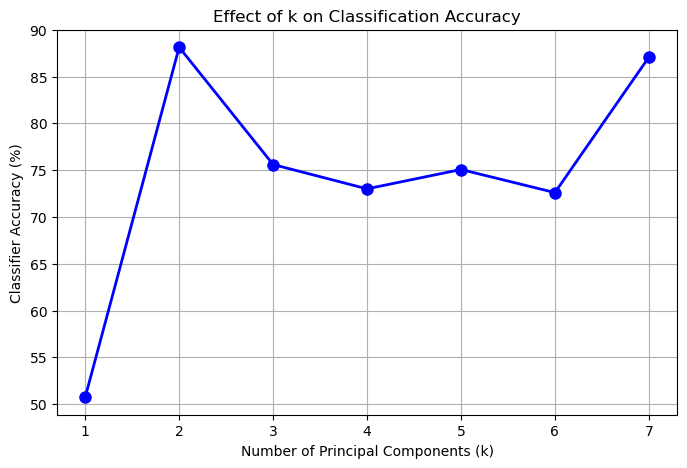

In [12]:
k_values = [1, 2, 3, 4, 5, 6, 7]  # Test these k values
accuracy_results = []  # Store accuracy results

for k in k_values:
    # Truncate to k-dimensional PCA space
    X_pca_k = X_pca[:, :k]

    # Compute centroids for each class
    unique_classes = np.unique(expanded_labels)
    centroids = {
        class_label: np.mean(X_pca_k[expanded_labels == class_label], axis=0)
        for class_label in unique_classes
    }

    # Assign each sample to the nearest centroid
    trained_labels = []
    for row in X_pca_k:
        # Compute distances to each centroid
        distances = {
            class_label: np.linalg.norm(row - centroid)
            for class_label, centroid in centroids.items()
        }
        # Nearest centroid = min distance
        trained_labels.append(min(distances, key=distances.get))

    # Evaluate accuracy
    # accuracy = accuracy_score(expanded_labels, trained_labels)
    # print(f"k={k}, Classifier accuracy = {accuracy * 100:.2f}%")
    accuracy = accuracy_score(expanded_labels, trained_labels)
    accuracy_results.append(accuracy * 100)
    print(f"k={k}, Classifier accuracy = {accuracy * 100:.2f}%")

# Plot k vs. accuracy
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracy_results, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Classifier Accuracy (%)")
plt.title("Effect of k on Classification Accuracy")
plt.grid(True)
plt.xticks(k_values)

# Display the plot
plt.show()

k=1, Test Classifier Accuracy = 48.67%
k=2, Test Classifier Accuracy = 98.33%
k=3, Test Classifier Accuracy = 92.33%
k=4, Test Classifier Accuracy = 74.67%
k=5, Test Classifier Accuracy = 91.67%
k=6, Test Classifier Accuracy = 71.67%
k=7, Test Classifier Accuracy = 94.33%


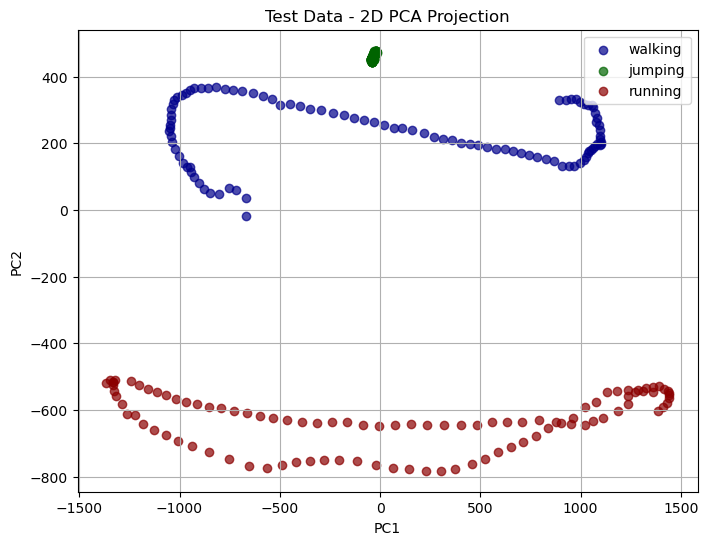

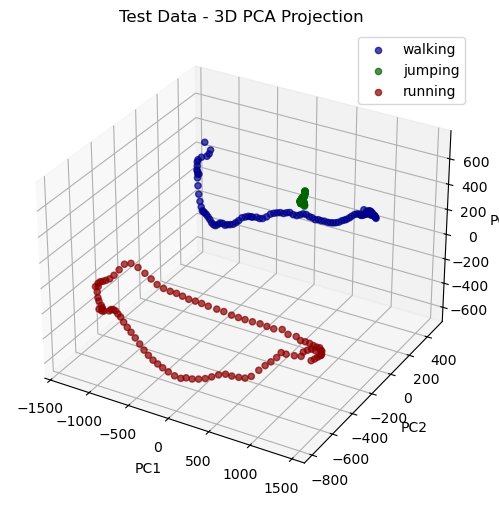

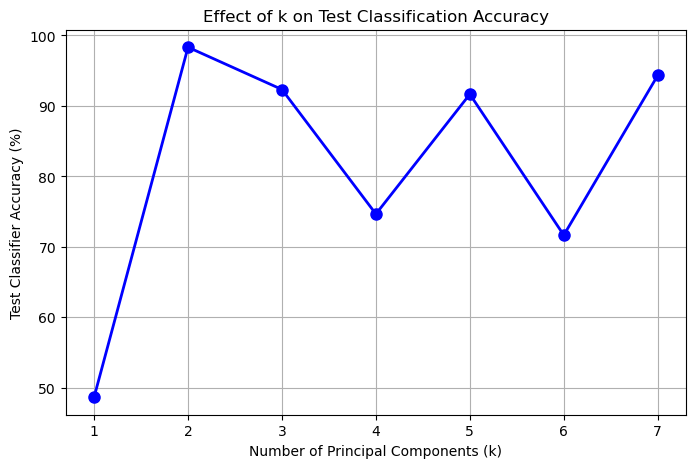

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import glob
import os

# Load test data
folder_test = "hw2data/test/"
test_files = sorted(glob.glob(os.path.join(folder_test, '*.npy')))
test_data_list = [np.reshape(np.load(f), (38, 3, -1)) for f in test_files]
X_test = np.concatenate(test_data_list, axis=2)  # Shape (38, 3, total_frames)

# Flatten the test data for PCA
X_test_flat = X_test.reshape(X_test.shape[0] * X_test.shape[1], -1).T

# Extract movement labels from filenames
test_labels_raw = [os.path.basename(f).split("_")[0] for f in test_files]
test_ground_truth_labels = np.array([label_map[label] for label in test_labels_raw])

# Ensure label alignment with test dataset
frames_per_sample_test = X_test_flat.shape[0] // len(test_files)
test_labels = np.repeat(test_ground_truth_labels, frames_per_sample_test)

# Apply PCA using the trained model from training data
X_test_pca = pca.transform(X_test_flat)

results = {}
accuracy_results = []
k_values = [1, 2, 3, 4, 5, 6, 7]

for k in k_values:
    # a) Truncate the Test Data to k Components
    X_test_pca_k = X_test_pca[:, :k]

    # b) Reuse the Centroids from Training in k Dimensions
    X_pca_k_train = X_pca[:, :k]  # From training step
    unique_classes = np.unique(expanded_labels)
    
    centroids = {
        class_label: np.mean(X_pca_k_train[expanded_labels == class_label], axis=0)
        for class_label in unique_classes
    }

    # c) Assign Each Test Sample to the Nearest Centroid
    test_predicted_labels = []
    for row in X_test_pca_k:
        distances = {class_label: np.linalg.norm(row - centroid) for class_label, centroid in centroids.items()}
        best_class = min(distances, key=distances.get)
        test_predicted_labels.append(best_class)

    # d) Compute Accuracy on Test Set
    test_accuracy = accuracy_score(test_labels, test_predicted_labels)
    accuracy_results.append(test_accuracy * 100)
    print(f"k={k}, Test Classifier Accuracy = {test_accuracy * 100:.2f}%")

    # e) Store Data for Visualization
    results[k] = {"X_test_pca_k": X_test_pca_k, "test_predicted_labels": test_predicted_labels}

colors = ["darkblue", "darkgreen", "darkred"]  # Ensure color consistency
label_color_map = {"walking": "darkblue", "jumping": "darkgreen", "running": "darkred"}

for k in [2, 3]:
    X_test_pca_k = results[k]["X_test_pca_k"]
    test_predicted_labels = results[k]["test_predicted_labels"]

    # 2D Plot for k=2
    if k == 2:
        plt.figure(figsize=(8, 6))
        for movement_name, label_id in label_map.items():
            idx = np.where(test_labels == label_id)[0]
            if idx.size > 0:
                plt.scatter(
                    X_test_pca_k[idx, 0], 
                    X_test_pca_k[idx, 1], 
                    color=label_color_map[movement_name], 
                    alpha=0.7, 
                    label=movement_name
                )
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.title("Test Data - 2D PCA Projection")
        plt.legend()
        plt.grid()
        plt.show()

    # 3D Plot for k=3
    elif k == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        for movement_name, label_id in label_map.items():
            idx = np.where(test_labels == label_id)[0]
            if idx.size > 0:
                ax.scatter(
                    X_test_pca_k[idx, 0], 
                    X_test_pca_k[idx, 1], 
                    X_test_pca_k[idx, 2], 
                    color=label_color_map[movement_name], 
                    alpha=0.7, 
                    label=movement_name
                )
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("Test Data - 3D PCA Projection")
        ax.legend()
        plt.show()

# Plot k vs. accuracy
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracy_results, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Test Classifier Accuracy (%)")
plt.title("Effect of k on Test Classification Accuracy")
plt.grid(True)
plt.xticks(k_values)
plt.show()


Kernel Choice: rbf
k=2: Train Accuracy: 35.20%, Test Accuracy: 33.33%
k=3: Train Accuracy: 35.60%, Test Accuracy: 33.33%
k=4: Train Accuracy: 35.93%, Test Accuracy: 33.33%
k=5: Train Accuracy: 36.60%, Test Accuracy: 33.33%
Kernel Choice: poly
k=2: Train Accuracy: 87.13%, Test Accuracy: 98.33%
k=3: Train Accuracy: 90.20%, Test Accuracy: 92.67%
k=4: Train Accuracy: 90.80%, Test Accuracy: 92.67%
k=5: Train Accuracy: 94.60%, Test Accuracy: 90.33%
Kernel Choice: sigmoid
k=2: Train Accuracy: 33.33%, Test Accuracy: 33.33%
k=3: Train Accuracy: 33.33%, Test Accuracy: 33.33%
k=4: Train Accuracy: 33.33%, Test Accuracy: 33.33%
k=5: Train Accuracy: 33.33%, Test Accuracy: 33.33%


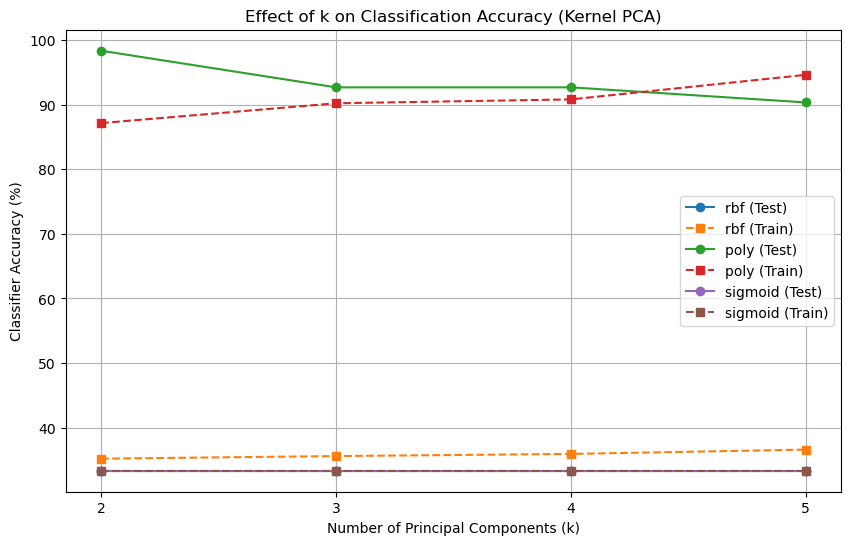

In [40]:
from sklearn.decomposition import KernelPCA
k_values = [2, 3, 4, 5]
kernel_choices = ['rbf', 'poly', 'sigmoid']
accuracy_results = {kernel: {"train": [], "test": []} for kernel in kernel_choices}

for kernel_choice in kernel_choices:
    print(f"Kernel Choice: {kernel_choice}")
    for k in k_values:
        # 1) Kernel PCA on training data
        kpca = KernelPCA(n_components=k, kernel=kernel_choice, gamma=0.1)
        X_train_kpca = kpca.fit_transform(X_train_flat)

        # 2) Build centroids for each class in the k-PCA space
        unique_labels = np.unique(expanded_labels)
        centroids_kpca = {}
        for lbl in unique_labels:
            centroids_kpca[lbl] = np.mean(X_train_kpca[expanded_labels == lbl], axis=0)

        # 3) Predict training labels by nearest centroid
        train_predicted_labels = []
        for row in X_train_kpca:
            distances = {lbl: np.linalg.norm(row - centroids_kpca[lbl]) 
                         for lbl in centroids_kpca}
            best_class = min(distances, key=distances.get)
            train_predicted_labels.append(best_class)
        train_accuracy = accuracy_score(expanded_labels, train_predicted_labels)

        # 4) Transform test data and predict
        X_test_kpca = kpca.transform(X_test_flat)
        test_predicted_labels = []
        for row in X_test_kpca:
            distances = {lbl: np.linalg.norm(row - centroids_kpca[lbl]) 
                         for lbl in centroids_kpca}
            best_class = min(distances, key=distances.get)
            test_predicted_labels.append(best_class)
        test_accuracy = accuracy_score(test_labels, test_predicted_labels)

        # 5) Store results for plotting
        accuracy_results[kernel_choice]["train"].append(train_accuracy * 100)
        accuracy_results[kernel_choice]["test"].append(test_accuracy * 100)

        # Print results
        print(f"k={k}: Train Accuracy: {train_accuracy * 100:.2f}%, "
              f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot k vs. accuracy for each kernel
plt.figure(figsize=(10, 6))
for kernel_choice in kernel_choices:
    plt.plot(k_values, accuracy_results[kernel_choice]["test"], marker='o', linestyle='-', label=f"{kernel_choice} (Test)")
    plt.plot(k_values, accuracy_results[kernel_choice]["train"], marker='s', linestyle='--', label=f"{kernel_choice} (Train)")

plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Classifier Accuracy (%)")
plt.title("Effect of k on Classification Accuracy (Kernel PCA)")
plt.grid(True)
plt.xticks(k_values)
plt.legend()
plt.show()
